#  Алгоритм Семантическо сегментации UNET

In [1]:
!pip install tensorflow_addons
from google.colab import drive
drive.mount("/content/gdrive")
!unzip gdrive/My\ Drive/Dataset.zip > /dev/null

Импортируем библиотеки

In [2]:

import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import cv2 as cv

from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.11.0
GPU is ON


Задаем входные параметры датасета

In [3]:
num_classes = 2
colors = np.array([(0, 0, 0),
                   (157, 234, 50)])
OUTPUT_SIZE = (256, 512)

### Функция загрузки и последующего преобразования датасета

In [4]:
def load_image(image_path):
    
    image = cv.imread(image_path)
    image = cv.resize(image, OUTPUT_SIZE)
#     image = image/255.
#     image = image.astype(np.float32)
    
    return image
  
def load_mask(mask_path):
    
    mask = cv.imread(mask_path)
    mask = cv.resize(mask, OUTPUT_SIZE)
    mask = mask[:,:,2]
#     mask = mask.astype(np.int32)
    return mask
  
def rectifying (image_path, mask_path):
    
    image = load_image(image_path)
    image.reshape([256,512, 3])
    
    mask = load_mask(mask_path)
    mask = tf.one_hot(mask, num_classes, dtype =  tf.int32)
    tf.reshape(mask, [256,512, num_classes])
    return image, mask

In [5]:
images_path = sorted(glob.glob('./Dataset/img/*.PNG'))
masks_path = sorted(glob.glob('./Dataset/mask/*.png'))

In [6]:
len(images_path)

511

In [7]:
img_train_num = 461
img_test_num = img_train_num + 50
from tqdm import tqdm
X_train, y_train = [], []
for x, y in tqdm(zip(images_path[:img_train_num], masks_path[:img_train_num])):
    x,y = rectifying (x, y)
    X_train.append(x)
    y_train.append(y)
# X_train, y_train = np.array(X_train),np.array(y_train)

X_test, y_test = [], []
for x, y in tqdm(zip(images_path[img_train_num:img_test_num], masks_path[img_train_num:img_test_num])):
    x,y = rectifying (x, y)
    X_test.append(x)
    y_test.append(y)
X_test, y_test = np.array(X_test),np.array(y_test)


461it [00:26, 17.71it/s]
50it [00:02, 24.30it/s]


## Просмотр набора данных

./Dataset/mask/IMG_0105.png


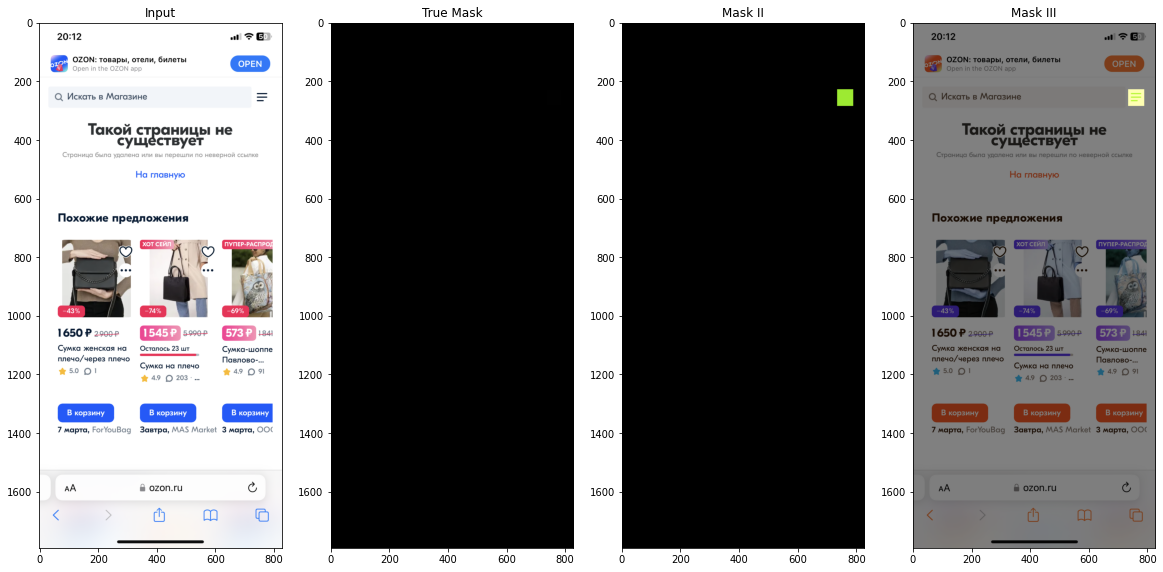

In [8]:
image = cv.imread(images_path[15])
mask = cv.imread(masks_path[15])
print(masks_path[0])
plt.figure(figsize = (20,70))


plt.subplot (1,4,1)
plt.title("Input")
plt.imshow (cv.cvtColor(image,cv.COLOR_BGR2RGB))

plt.subplot(1,4,2)
plt.title("True Mask")
plt.imshow (mask)

plt.subplot (1,4,3)
plt.title("Mask II")
plt.imshow (colors[mask[:,:,2]])

plt.subplot (1,4,4)
plt.title("Mask III")
plt.imshow (cv.addWeighted(image.astype(np.int32), 0.5,colors[mask[:,:,2]].astype(np.int32), 1.,0))
plt.show()




### Функция  аугментации
Данная функция предназначена для исскуственного увеличения размера датасета за счет копирования и последующего преобразования изображений

In [9]:
def augmentate_images(image, masks):   
    
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    return image, masks

In [10]:
XX_train = []
yy_train = []
for i in range (2):
    for x,y in zip(X_train, y_train):
        x_aug,y_aug = augmentate_images(x,y)
        XX_train.append(x_aug)
        yy_train.append(y_aug)

XX_train = XX_train + X_train
yy_train = yy_train + y_train
XX_train, yy_train = np.array(XX_train),np.array(yy_train)

print(len(XX_train))
print(len(yy_train))



1383
1383


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid= train_test_split(XX_train, yy_train, random_state = 42, test_size = 0.2)
X_train, X_valid, y_train, y_valid = np.array(X_train), np.array(X_valid), np.array(y_train), np.array(y_valid)

### Unet Model


In [11]:
input_SIZE = (512,256)
def input_layer():
    return tf.keras.layers.Input(shape= input_SIZE + (3,))
inp_layer = input_layer()
inp_layer

<KerasTensor: shape=(None, 512, 256, 3) dtype=float32 (created by layer 'input_1')>

In [12]:
from keras.models import Sequential, load_model
import tensorflow_addons as tfa
from keras.layers import Conv2D, MaxPool2D,UpSampling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2DTranspose, LeakyReLU, ReLU
from keras.optimizers import Adam as adam
from keras.optimizers import SGD
from keras.metrics import RootMeanSquaredError
from keras import initializers
import math

def downsample_block(filters, size):
    initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)
    
    result =Sequential()

    result.add(Conv2D(filters, size,padding='same',kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization(momentum=0.9, epsilon=1e-5))
    result.add(ReLU())

    result.add(Conv2D(filters, size, padding='same',kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization(momentum=0.9, epsilon=1e-5))
    result.add(ReLU())
    
    result.add(MaxPool2D(pool_size = 2, padding='same'))
    result.add(BatchNormalization(momentum=0.9, epsilon=1e-5))
    result.add(ReLU())

    return result


def upsample_block(filters, size, dropout_true=False, dropout=0.05, last_layer=False,bottelneck = False):
    initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

    result = Sequential()

    if bottelneck:
      # result.add(UpSampling2D(size=(2, 2)))
      result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    else:
      result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
            
      result.add(Conv2D(filters, size, padding='same',kernel_initializer=initializer, use_bias=False))
      result.add(BatchNormalization(momentum=0.9, epsilon=1e-5))
      result.add(ReLU())
      if dropout_true:
        result.add(Dropout(dropout))

      result.add(Conv2D(filters, size,padding='same',kernel_initializer=initializer, use_bias=False))
      result.add(BatchNormalization(momentum=0.9, epsilon=1e-5))
      result.add(ReLU())
      if dropout_true:
        result.add(Dropout(dropout))

      # if last_layer:
      #       result.add(Conv2D(filters, 1,padding='same',activation = 'ReLU',kernel_initializer=initializer, use_bias=False))
    
    return result


def output_layer(size):
    initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)
    return  Conv2DTranspose(32, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)

def prelast_conv_layer(filters, size):
    initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)
    return  Conv2D(filters, size,padding='same',activation = 'ReLU',kernel_initializer=initializer, use_bias=False)

def last_conv_layer(filters, size):
    initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)
    return  Conv2D(filters, size,padding='same',activation = 'sigmoid',kernel_initializer=initializer, use_bias=False)


In [13]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(32, 3),
    downsample_block(64, 3),
    downsample_block(128, 3),
    downsample_block(256, 3),
    downsample_block(512, 3)]

In [14]:
upsample_stack = [
    upsample_block(512, 3, bottelneck = True),
    upsample_block(256, 3,dropout_true=True, dropout=0.15),
    upsample_block(128, 3,dropout_true=True, dropout=0.10),
    upsample_block(64, 3,dropout_true=True, dropout=0.05),
    upsample_block(32, 3,dropout_true=True,last_layer=True, dropout=0.05)]

out_layer = output_layer(3)
last3conv_layer = prelast_conv_layer(32,3)
last1conv_layer = last_conv_layer(num_classes, 1)

In [15]:
x = inp_layer
downsample_skips = []
for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)

downsample_skips[:-1]

[<KerasTensor: shape=(None, 256, 128, 32) dtype=float32 (created by layer 'sequential')>,
 <KerasTensor: shape=(None, 128, 64, 64) dtype=float32 (created by layer 'sequential_1')>,
 <KerasTensor: shape=(None, 64, 32, 128) dtype=float32 (created by layer 'sequential_2')>,
 <KerasTensor: shape=(None, 32, 16, 256) dtype=float32 (created by layer 'sequential_3')>]

In [16]:
downsample_skips  = downsample_skips[:-1]
downsample_skips = reversed(downsample_skips)

In [17]:
upsample_skips = []
for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    upsample_skips.append(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

In [18]:
upsample_skips

[<KerasTensor: shape=(None, 32, 16, 512) dtype=float32 (created by layer 'sequential_5')>,
 <KerasTensor: shape=(None, 64, 32, 256) dtype=float32 (created by layer 'sequential_6')>,
 <KerasTensor: shape=(None, 128, 64, 128) dtype=float32 (created by layer 'sequential_7')>,
 <KerasTensor: shape=(None, 256, 128, 64) dtype=float32 (created by layer 'sequential_8')>]

In [19]:
out_layer = out_layer(x)
out_layer = last3conv_layer(out_layer)
out_layer = last3conv_layer(out_layer)
out_layer = last1conv_layer(out_layer)

In [20]:
unet = tf.keras.Model(inputs=inp_layer, outputs=out_layer)
tf.keras.utils.plot_model(unet, show_shapes=True, dpi=72)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 128, 32  10464       ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 128, 64, 64)  56064       ['sequential[0][0]']             
                                                                                              

In [21]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_one_hot_io_u"]
        if accuracy >= self.point:
            self.model.stop_training = True


In [22]:
from keras import metrics

unet.compile(optimizer='adam',loss='binary_crossentropy', metrics=[metrics.OneHotIoU(num_classes,[i for i in range(0,num_classes)])])

In [ ]:
history = unet.fit(X_train,y_train, validation_data=[X_valid, y_valid],batch_size=4, epochs=50,callbacks = [StopOnPoint(0.95)])

Epoch 1/50
277/277 [==============================] - 109s 321ms/step - loss: 0.0315 - one_hot_io_u: 0.5356 - val_loss: 0.0020 - val_one_hot_io_u: 0.8514
Epoch 2/50
277/277 [==============================] - 84s 304ms/step - loss: 0.0032 - one_hot_io_u: 0.7892 - val_loss: 0.0019 - val_one_hot_io_u: 0.8597
Epoch 3/50
277/277 [==============================] - 84s 304ms/step - loss: 0.0028 - one_hot_io_u: 0.8026 - val_loss: 0.0019 - val_one_hot_io_u: 0.8618
Epoch 4/50
277/277 [==============================] - 84s 304ms/step - loss: 0.0024 - one_hot_io_u: 0.8226 - val_loss: 0.0022 - val_one_hot_io_u: 0.8416
Epoch 5/50
277/277 [==============================] - 85s 306ms/step - loss: 0.0021 - one_hot_io_u: 0.8330 - val_loss: 0.0016 - val_one_hot_io_u: 0.8548
Epoch 6/50
277/277 [==============================] - 84s 304ms/step - loss: 0.0020 - one_hot_io_u: 0.8388 - val_loss: 0.0015 - val_one_hot_io_u: 0.8543
Epoch 7/50
277/277 [==============================] - 85s 306ms/step - loss: 0.00

In [ ]:
# #plotting graphs for accuracy 
# plt.figure(0)
# plt.plot(history.history['one_hot_io_u'], label='training one_hot_io_u')
# plt.plot(history.history['val_one_hot_io_u'], label='val_one_hot_io_u')
# plt.title('one_hot_io_u_1')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()
# plt.figure(1)
# plt.plot(history.history['loss'], label='training loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.title('Loss')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend()
# plt.show()

In [ ]:
ALL_PRED = []
for x, y in zip(X_test, y_test):
    
    pred = unet(np.array([x]))
    pred = np.argmax (pred, axis=-1) [0, :,:]

    y = np.argmax(y, axis=-1)

    iou = tf.keras.metrics.MeanIoU(num_classes=23)
    iou.update_state(pred, y)

    plt.figure(figsize = (30,30))

    plt.subplot (1,4,1)
    plt.title("Input")
    plt.imshow (cv.cvtColor(x,cv.COLOR_BGR2RGB))

    plt.subplot(1,4,2)
    plt.title("True Mask")
    plt.imshow (colors[y])
    
    plt.subplot (1,4,3)
    plt.title("Model Prediction")
    plt.imshow (colors [pred])
    
    plt.subplot (1,4,4)
    plt.title("Model Prediction")
    plt.imshow (cv.addWeighted(x.astype(np.int32), 0.5,colors[pred].astype(np.int32), 1.,0))
    plt.show()
    
    print(iou.result().numpy())
    ALL_PRED.append(iou.result().numpy())


In [ ]:
def Average(lst):
    return sum(lst) / len(lst)
 
# Driver Code
average = Average(ALL_PRED)

In [ ]:
average

In [ ]:
unet.save('./burger_menu_finder(0.91).h5')